In [2]:
from collections import Counter

import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

import shap
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
from utils import get_logger, readJSON, preprocess
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
print('加载依赖库')

加载依赖库


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题
sns.set(font='SimHei', font_scale=0.8)        # 解决Seaborn中文显示问题

In [4]:
use_pearson = False
use_chi2 = False
use_MIC = False

In [5]:
zhenghou2id = readJSON('./input/zhenghou2id.json')
id2feature = readJSON('./input/id2feature.json')
logger = get_logger(logger_name=__name__, filename='./log/one_other.log')
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
N = 15
Accuracy = []
Precision = []
Recall = []
F1 = []
X, y = preprocess(path='./input/心总表.xlsx', sheet_name='总表')
X.columns = id2feature.values()
le = LabelEncoder()
y = le.fit_transform(y)

<AxesSubplot:>

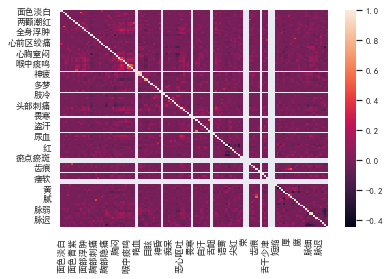

In [6]:
sns.heatmap(X.corr())

In [7]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest,chi2
SelectKBest(chi2,k=100).fit_transform(X,y)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

  0%|          | 0/8 [00:00<?, ?it/s]

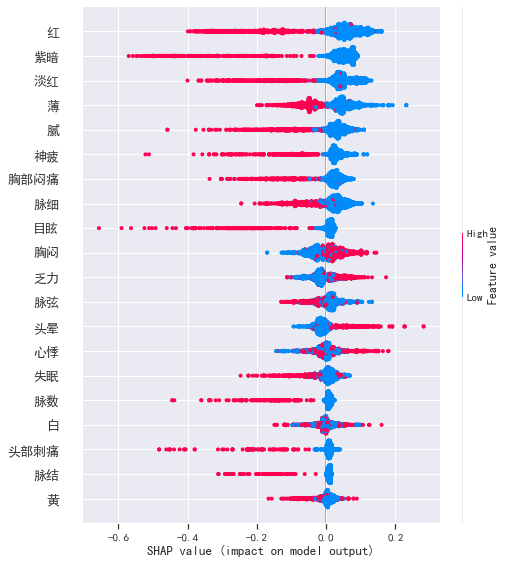

 12%|█▎        | 1/8 [00:06<00:42,  6.09s/it]

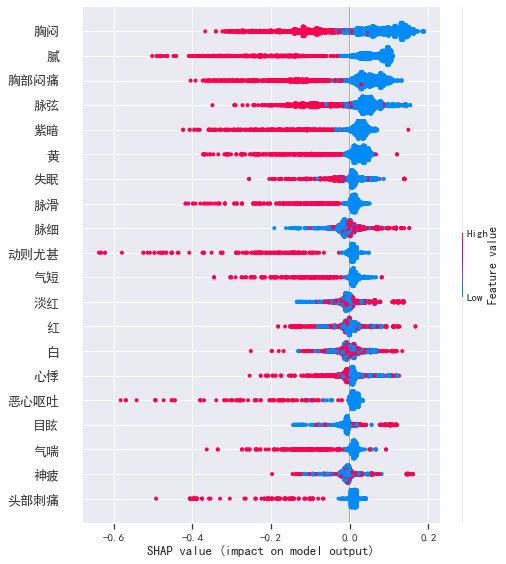

 25%|██▌       | 2/8 [00:12<00:39,  6.57s/it]

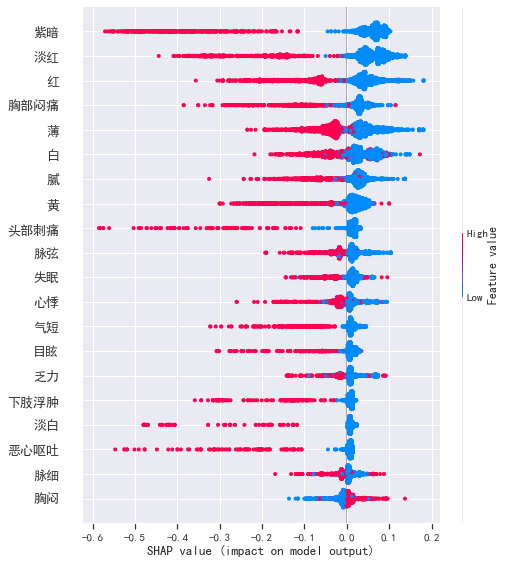

 38%|███▊      | 3/8 [00:19<00:32,  6.52s/it]

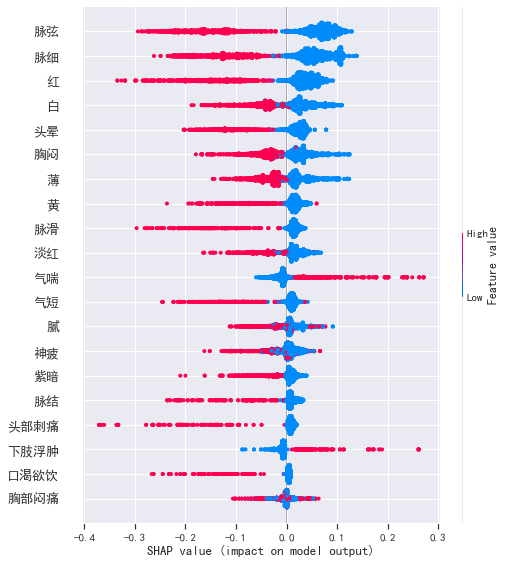

 50%|█████     | 4/8 [00:26<00:26,  6.69s/it]

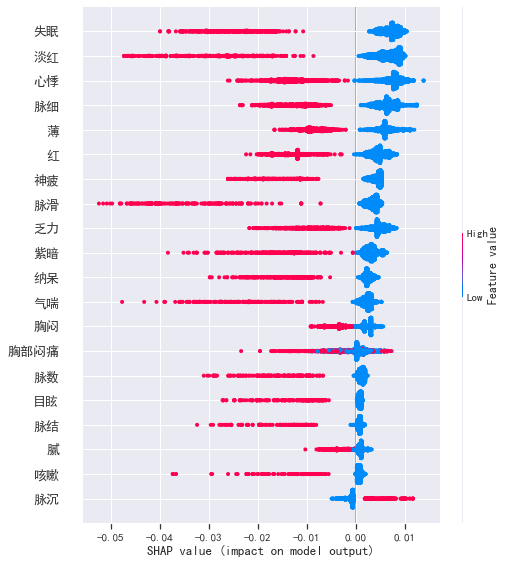

 62%|██████▎   | 5/8 [00:31<00:18,  6.27s/it]

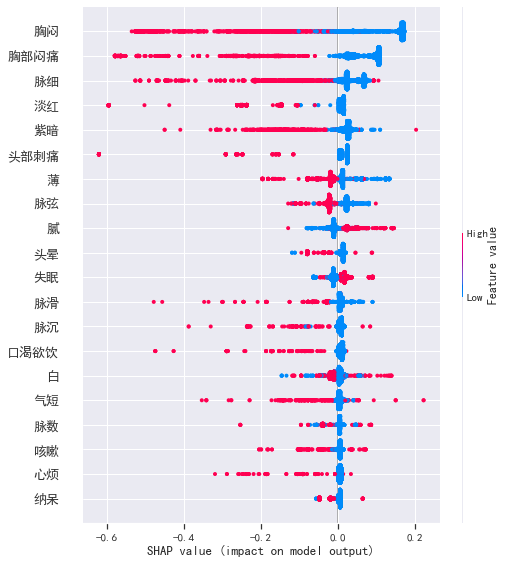

 75%|███████▌  | 6/8 [00:37<00:12,  6.18s/it]

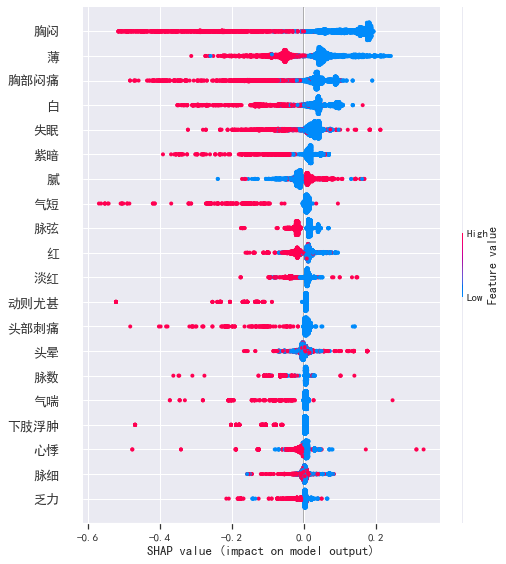

 88%|████████▊ | 7/8 [00:44<00:06,  6.27s/it]

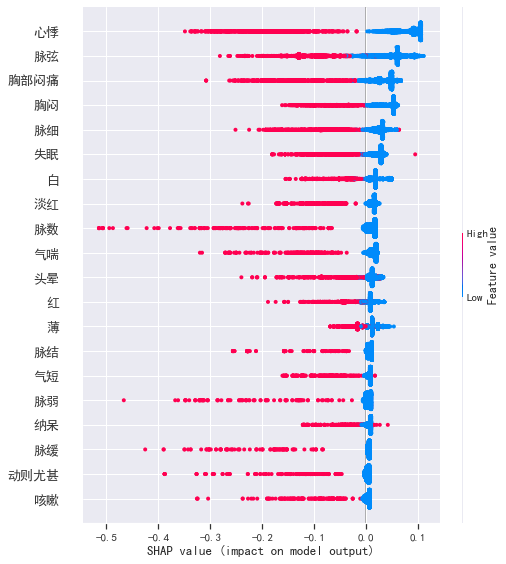

100%|██████████| 8/8 [00:50<00:00,  6.32s/it]


In [14]:
for i in tqdm(range(8)):
    target = np.where(y == i, 1, 0)
    target = pd.DataFrame(data=target, columns=['证名'])
    X_ = X.copy()
    target_ = target.copy()
    X_.reset_index(drop=True, inplace=True)
    target_.reset_index(drop=True, inplace=True)
    tmp = pd.concat([X_, target_], axis=1)
    tmp1 = tmp[tmp['证名'] == 1][:100]
    tmp0 = tmp[tmp['证名'] == 0]
    tmp = pd.concat([tmp1, tmp0], axis=0)
    target_ = tmp['证名']
    X_ = tmp.drop(columns=['证名'])
    smote_tomek = SMOTETomek(random_state=0)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_, target_)


    def objective(trial):
        train_x, valid_x, train_y, valid_y = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=7)
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dvalid = xgb.DMatrix(valid_x, label=valid_y)
        param = {
            'verbosity': 0,
            'objective': 'binary:logistic',
            'tree_method': 'exact',
            'booster': 'gbtree',
            # 'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.2, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'max_depth': trial.suggest_int("max_depth", 3, 9, step=2),
            'min_child_weight': trial.suggest_int("min_child_weight", 2, 10),
            'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
            'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }
        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        accuracy = accuracy_score(valid_y, preds)
        return accuracy


    study = optuna.create_study(direction="maximize", study_name='xgb_optuna')
    study.optimize(objective, n_trials=100, timeout=600)
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    SHAP_total_topN = {}
    weight_total_topN = {}
    gain_total_topN = {}
    total_gain_total_topN = {}
    total_cover_total_topN = {}
    key = 1
    # fig,ax = plt.subplots(8,1)
    for train_index, test_index in kf.split(X_resampled, y_resampled):
        dtrain = xgb.DMatrix(X_resampled.loc[train_index], label=y_resampled.loc[train_index])
        dvalid = xgb.DMatrix(X_resampled.loc[test_index], label=y_resampled.loc[test_index])
        model = xgb.train(study.best_trial.params, dtrain)
        # plt.subplot(8,1,1)
        # ax = plt.subplot(10,1,key)


        preds = model.predict(dvalid)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0


        accuracy = accuracy_score(y_resampled.loc[test_index], preds)
        Accuracy.append(accuracy)
        precision = precision_score(y_resampled.loc[test_index], preds)
        Precision.append(precision)
        recall = recall_score(y_resampled.loc[test_index], preds)
        Recall.append(recall)
        f1 = f1_score(y_resampled.loc[test_index], preds)
        F1.append(f1)
        model_weight = sorted(model.get_score(importance_type='weight').items(),key=lambda value: value[1],reverse=True)
        model_gain = sorted(model.get_score(importance_type='gain').items(),key=lambda value: value[1],reverse=True)
        model_cover = sorted(model.get_score(importance_type='cover').items(),key=lambda value: value[1],reverse=True)
        model_total_gain = sorted(model.get_score(importance_type='total_gain').items(),key=lambda value: value[1],reverse=True)
        model_total_cover = sorted(model.get_score(importance_type='total_cover').items(),key=lambda value: value[1],reverse=True)

        model_weight_key = [i[0] for i in model_weight]
        model_gain_key = [i[0] for i in model_gain]
        model_cover_key = [i[0] for i in model_cover]
        model_total_gain_key = [i[0] for i in model_total_gain]
        model_total_cover_key = [i[0] for i in model_total_cover]


        explainer = shap.TreeExplainer(model)
        shap_values_XGBoost_train = explainer.shap_values(X_resampled.loc[train_index])
        if key==1:
            shap.summary_plot(shap_values_XGBoost_train,X_resampled.iloc[train_index])
        SHAP_XGBoost = pd.DataFrame(data=shap_values_XGBoost_train, columns=X_resampled.loc[train_index].columns).mean(
            axis=0).sort_values(
            ascending=False)
        SHAP_topN = list(SHAP_XGBoost.items())
        # topN = [readJSON('./input/id2feature.json')[i[0]] for i in SHAP_topN]
        SHAP_total_topN[key] = SHAP_topN
        key = key + 1
        # topN_detail = [(id2feature[i[0]], round(i[1], 3)) for i in SHAP_topN]
        logger.info(f'{zhenghou2id[str(i+1)]}\t{round(accuracy, 3)}\t{round(precision, 3)}\t{round(recall, 3)}\t{round(f1, 3)}')
        logger.info(f'weight\t{model_weight_key}')
        logger.info(f'gain\t{model_gain_key}')
        logger.info(f'cover\t{model_cover_key}')
        logger.info(f'total_gain\t{model_total_gain_key}')
        logger.info(f'total_cover\t{model_total_cover_key}')
        logger.info(f'SHAP\t{list(SHAP_XGBoost.keys())}')
    uniqueFeature = set(SHAP_total_topN[1])
    featureFrequency = Counter([])
    for item in SHAP_total_topN:
        uniqueFeature = uniqueFeature & set(SHAP_total_topN[item])
        featureFrequency = featureFrequency + Counter(SHAP_total_topN[item])

    logger.info(f'{zhenghou2id[str(i+1)]}SHAP特征交集：\t{uniqueFeature}')
    logger.info(f'{zhenghou2id[str(i+1)]}频数：\t{sorted(featureFrequency.items(), key=lambda pair: pair[1], reverse=True)}')
    logger.info(f'{zhenghou2id[str(i+1)]}均值：\t{round(np.mean(Accuracy), 3)}\t{round(np.mean(Precision), 3)}\t'
                f'{round(np.mean(Recall), 3)}\t{round(np.mean(F1), 3)}')